### Exploration notebook 

#### Goal: predict meter readings (as a proxy for cooling) for arbitrary buildings in arbitrary location
#### for future weather (as predicted in climate models)

- Aside from exploring the data towards the specific prediction task, we will also try and asses the following:
    1. Is CDD an appropriate measure? 
    2. If so, what is a sensible threshold for it?

#### Still to add: 
- Are weekends different in dist. than non weekend 
- Add number of observations per meter reading for further justification to drop meters except 0
- check if there are duplicates of any sort
- find missing dates per site
- detailed conclusions per plot/set of plots
- re-write Exploration conclusions  
- Think how to split dataset to train and test in order to generalize
- Add wind direction rose
- Add some stats on year built


#### Import packages

In [1]:
from IPython.display import Image, HTML
import cdd_analysis as cdd
import read_n_join as rj
import formatting as fm
import cleanup as clup
import feat_eng as fe
import plotter as plo
import pandas as pd
import warnings

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

#### Functions 

In [3]:
def nice_display(element, names):
    '''
    Prints a nice version of a series/list/array on the screen
    ----------
    Parameters:
    element: series/pandas df/array/list
    names: column names to present on screen for provided element
    ----------

    '''
    display(HTML(pd.DataFrame(element, columns=names).to_html()))

### Read data

In [4]:
raw_df, meta = rj.read_n_join_data('ashrae-energy-prediction')

### Dataset columns

In [5]:
nice_display(raw_df.columns, ["columns"])

,columns
0,building_id
1,meter
2,timestamp
3,meter_reading
4,site_id
5,primary_use
6,square_feet
7,year_built
8,floor_count
9,air_temperature


- meter column means: 
    - 0: Electricity
    - 1: Chilled water
    - 2: Steam
    - 3: Hot water
* since we want to concentrate on cooling we will limit our task to meter of type 0
 - action: drop other meters

### is building id unique?  YES!

In [6]:
print('Total # of buidings are {}, but we only have {} unique ids'.format(sum(raw_df.groupby('site_id').nunique()['building_id']), 
                                                                          raw_df['building_id'].nunique()))

Total # of buidings are 1449, but we only have 1449 unique ids


### Missing values

In [7]:
nice_display(plo.missing_per_col(raw_df), names = ["Missing values percentage"])

,Missing values percentage
floor_count,0.826528
year_built,0.599900
cloud_coverage,0.436551
precip_depth_1_hr,0.185447
wind_direction,0.071678
sea_level_pressure,0.060925
wind_speed,0.007107
dew_temperature,0.004953
air_temperature,0.004781


 - Can we infer precip due to clous coverage?
 - Can we infer wind direction?
 - Can we say something cause all are in northern hemisphere?

Actions: 
    - drop floor count
    - maybe drop year built
    - maybe drop cloud coverage? see below it's correlated to dew and precip

### Number of buildings per site

In [8]:
nice_display(raw_df.groupby('site_id').nunique()['building_id'], names = ['building_id'])

,building_id
site_id,
0,105
1,51
2,135
3,274
4,91
5,89
6,44
7,15
8,70


#### What types of buildings do we have?

In [9]:
nice_display(raw_df.primary_use.unique(), names = ['primary use'])

,primary use
0,Education
1,Lodging/residential
2,Office
3,Entertainment/public assembly
4,Other
5,Retail
6,Parking
7,Public services
8,Warehouse/storage
9,Food sales and service


Actions:
- Seems reasonable to remove parking altogether - cooling is not really part of its usage
- Pay attention that the # of buildings differ so we have the risk of weighting more one site rather than other sites
  - options:
        - Use some mechanism to upsample/downsample 
        - Adapt the loss function to downplay over oberved sites
        - Use a model that tells us that the observations which came from one site are correlated with each other and is able to extrapolate new sites (GP/ mixed model effect) -- a model that would just one hot encode will have two problems: 1. can't look at new sites, 2. variables that are shared among all sites will be driven twoards over represented site.

### Clean data

In [12]:
# df = cleanup(raw_df)

In [13]:
# df = one_hot(df, ['mon', 'weekday', 'year_built', 'primary_use', 'site_id'])

#### Input vars.

In [10]:
cols_to_str = ['building_id', 'year_built']
ones_to_drop = ['wind_direction']
ones_to_hot = ['mon', 'weekday', 'year_built', 'primary_use', 'site_id']

In [12]:
df = fm.formatting(raw_df, 'timestamp', cols_to_str)
df = fe.feature_engineer(df, 'timestamp', 'building_id', 'site_id')
df = clup.drop_redundant(df, ones_to_drop)

### Percentage of zeros per site and month

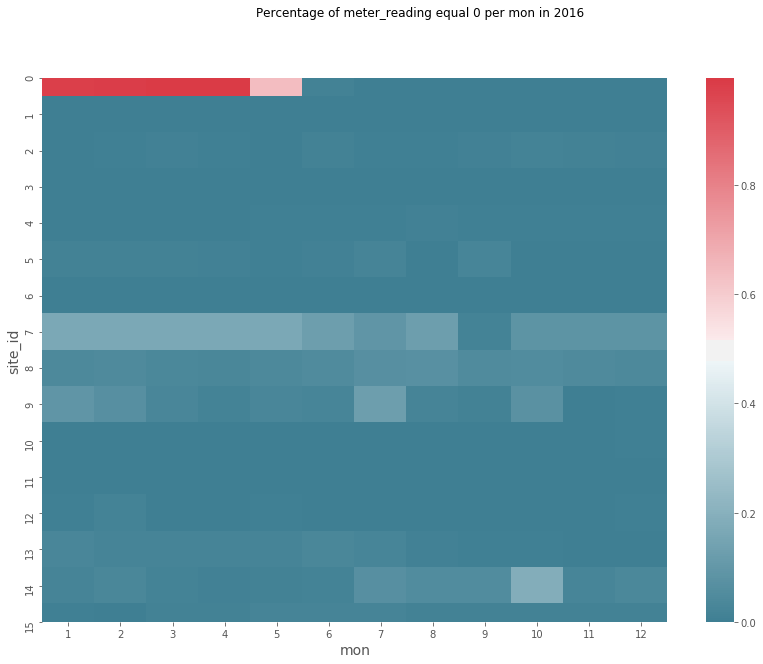

In [13]:
plo.heatmap_percentage_of_zeros_per_class_and_time(df, 'meter_reading', 'site_id', 'mon')

- Actions:
    - remove months 1-5 incl. from site 0
    - explore further why there are many zeros at site 0, 7, 9 and 14

### Night vs. daytime meter readings

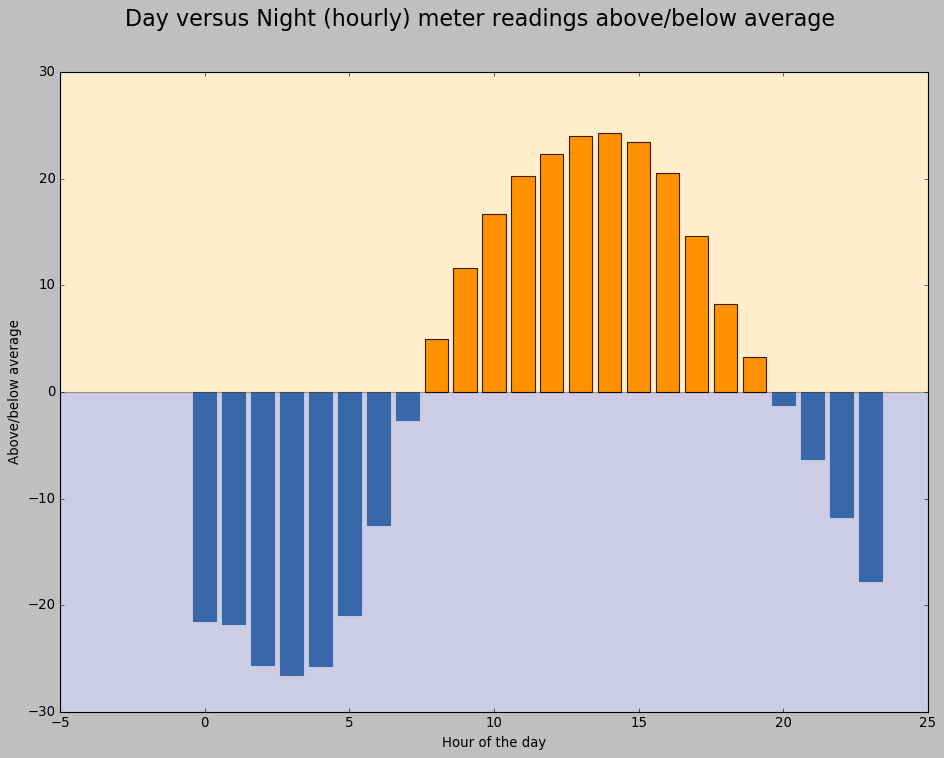

In [16]:
plo.day_vs_night_consumption(df, 'meter_reading')

- Actions:
    If constructing an hourly model, add a feature for day/night (one-hot)

### Meter readings -- per site

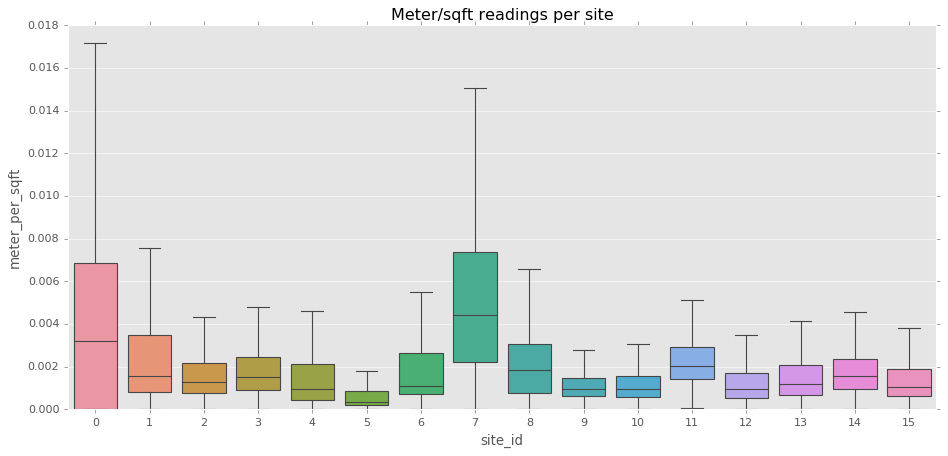

In [19]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plo.plot_sns_multi_boxplots_one_class(df, 'site_id', 'meter_per_sqft', 'Meter/sqft readings per site')

### Meter readings -- same site different usages:

class is:  12


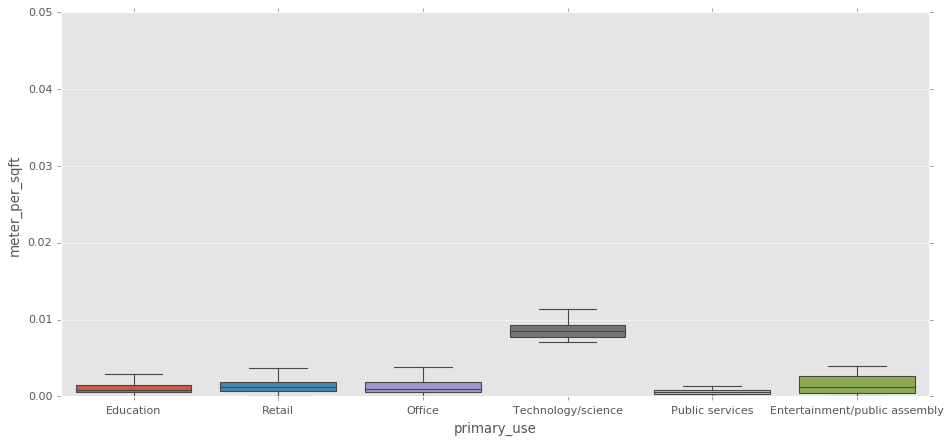

class is:  3


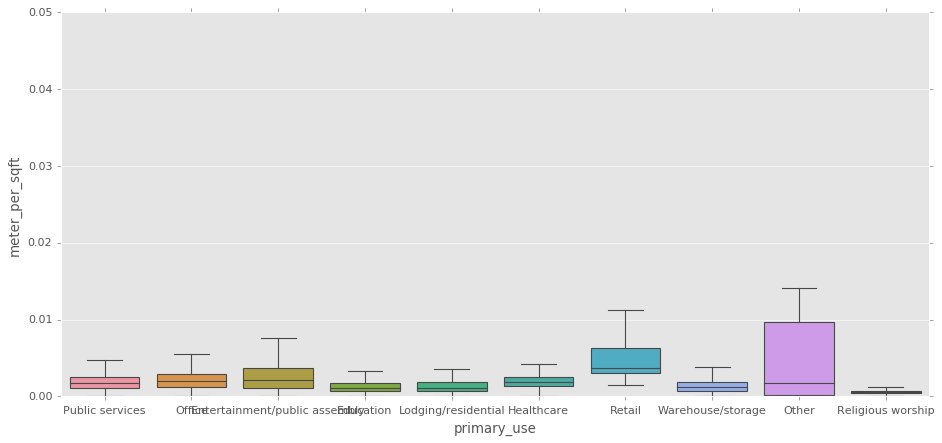

class is:  0


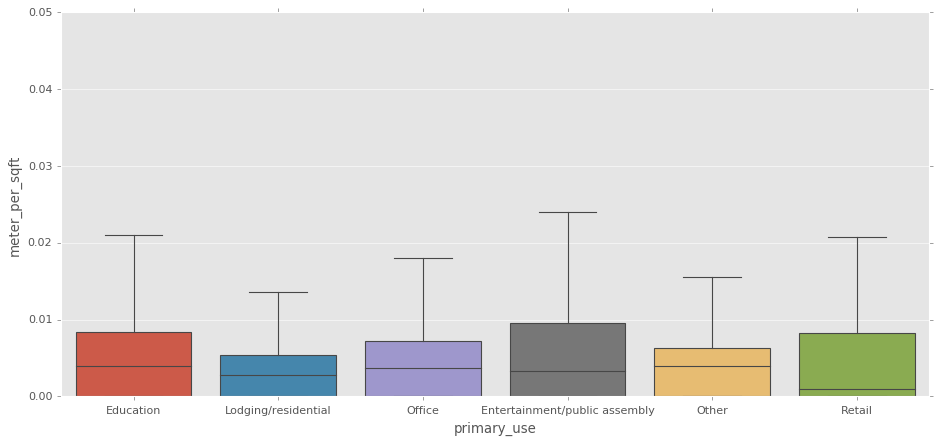

class is:  12


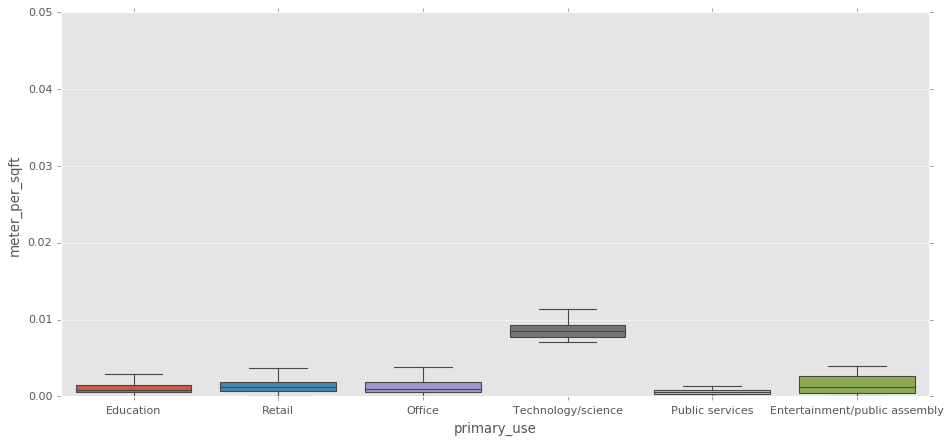

In [20]:
plo.plot_sns_usages_multi_boxplots_multi_class(df, x = 'primary_use', y = 'meter_per_sqft', class_col= 'site_id')

- different usages have different distributions from same site

### Meter readings -- different sites same usage

class is:  Lodging/residential


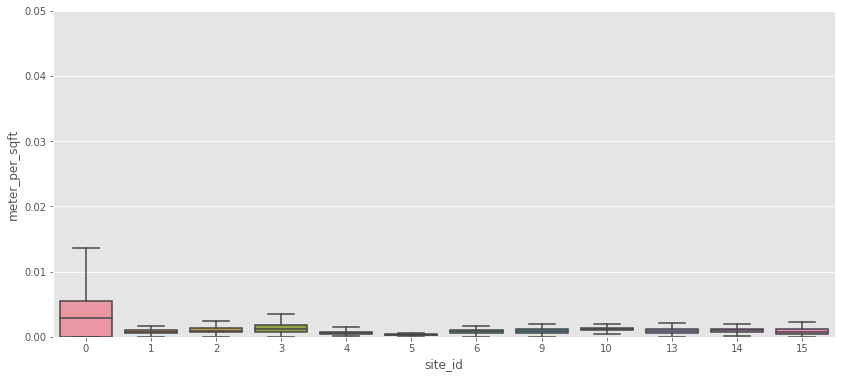

class is:  Lodging/residential


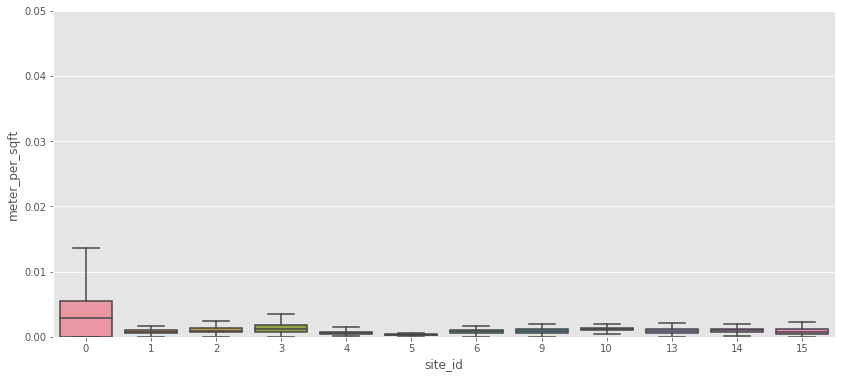

class is:  Education


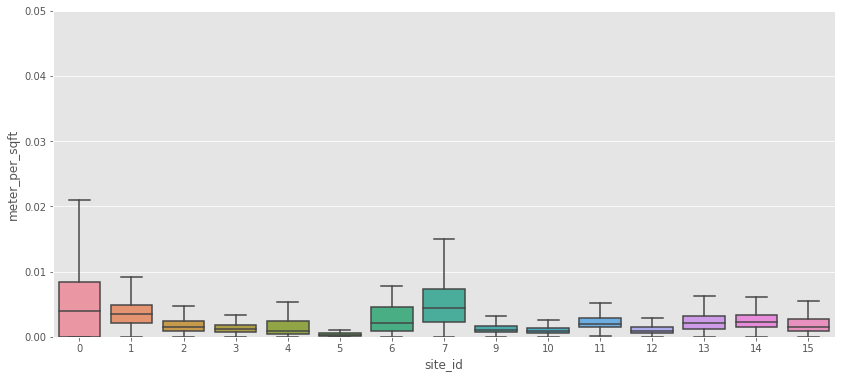

class is:  Utility


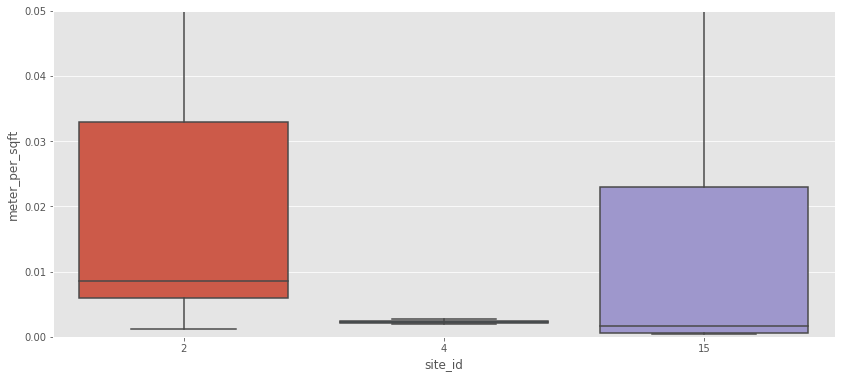

In [23]:
plo.plot_sns_usages_multi_boxplots_multi_class(df, x = 'site_id', y = 'meter_per_sqft', class_col = 'primary_use')

- Different sites have differernt distributions for same usage
 
Actions:
    - Since distributions are different per site and primary usage --> remove outliers per site and usage 

### Meter readings over time per site

In [21]:
df['site_id'] = df['site_id'].astype(int)
df2 = df.groupby(['date', 'site_id']).mean().reset_index()[['date', 'site_id' ,'meter_per_sqft', 'air_temperature']]

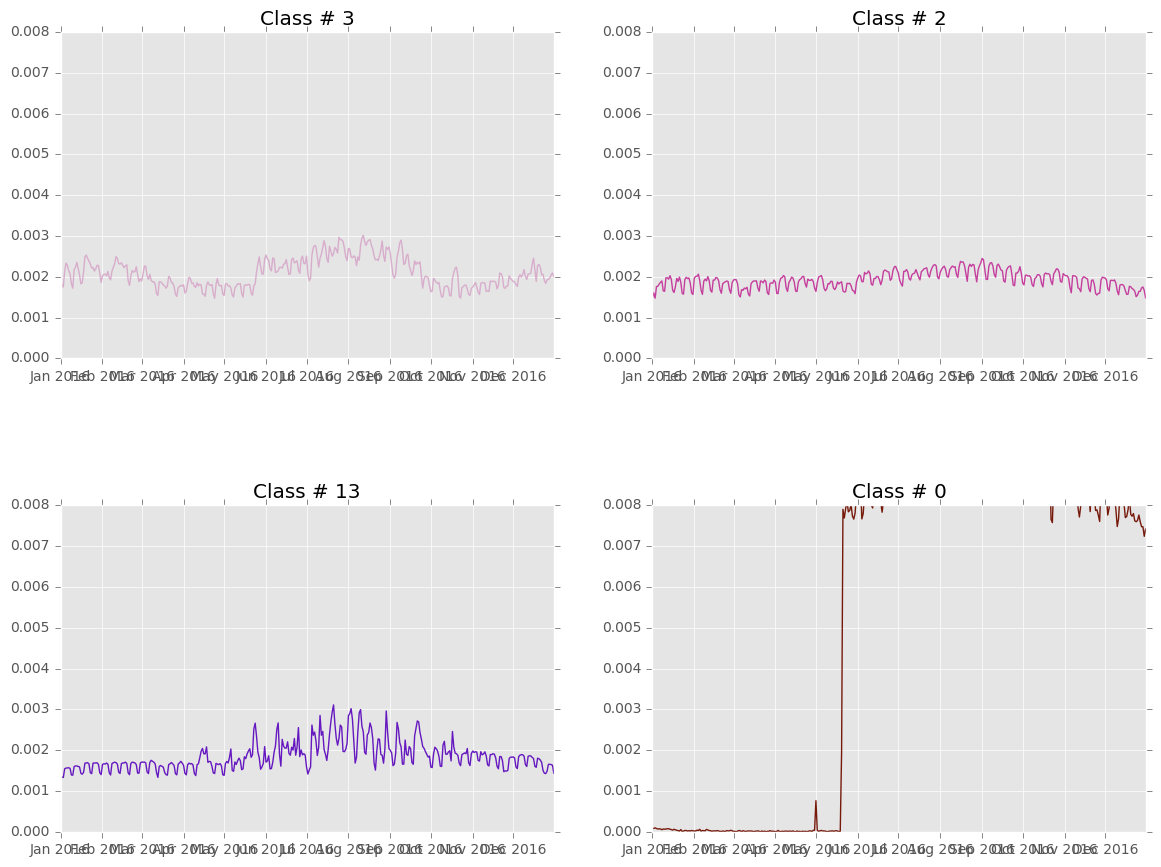

In [22]:
plo.line_subplots_per_class(df2[['date', 'site_id', 'meter_per_sqft']], 'date', 'meter_per_sqft', 2, 2, 'site_id', 0, 0.008)

- Meter readings behave differently in different sites
- Meter readings in each site seem to have a range of values they wiggle between (bias). i.e. in a model that we construct we would like to have a term representing site bias
- Actions: 
    - add site bias (r.v with certain variance)

# Weather per site over time 2016

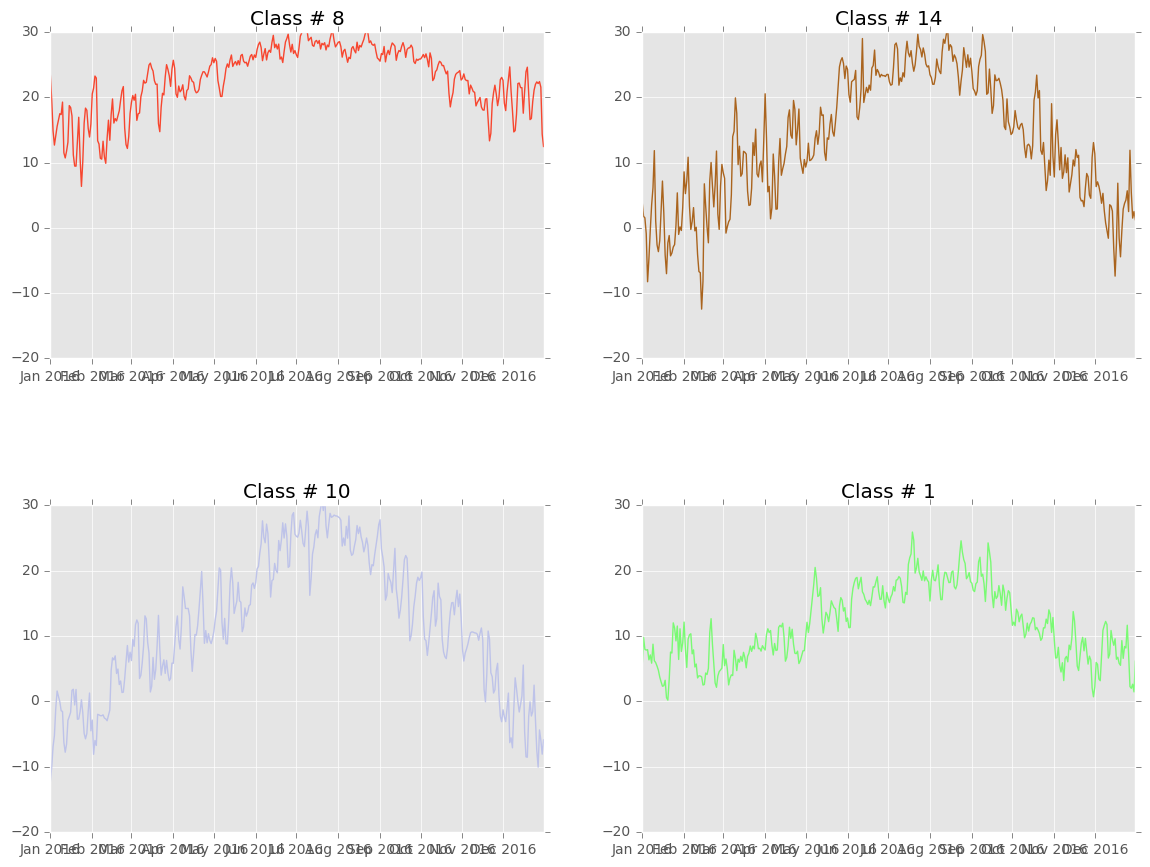

In [23]:
plo.line_subplots_per_class(df2[['date', 'site_id', 'air_temperature']], 'date', 'air_temperature', 2, 2, 'site_id', -20, 30)

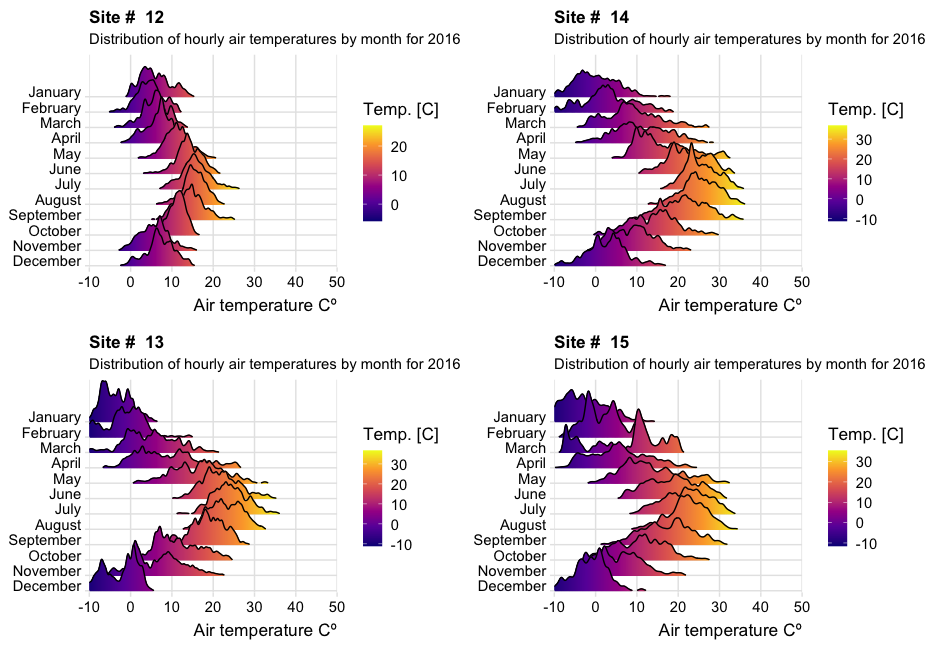

In [24]:
Image("./extra_plots/site_12_15.png")

- The two sets of plots above are shedding light on two things:
    1. All sites share the same summer/winter time (northern hemisphere) - weather among sites seems to be correlated and should be reflected in the chosen model
    2. The distribution of meter readings within each month seems to follow a mixture of gausians maybe? 

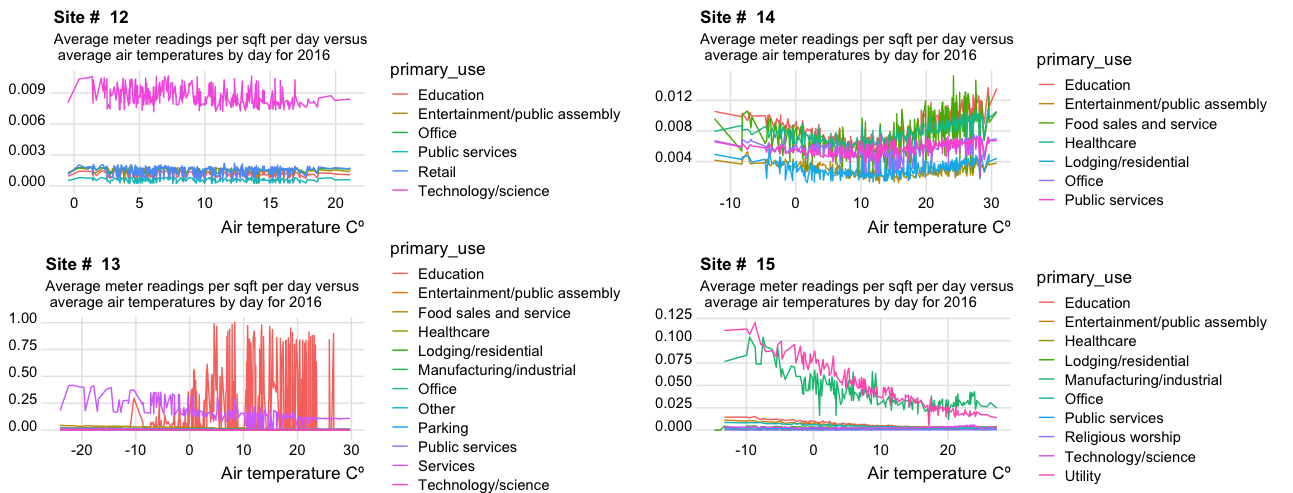

In [25]:
Image('./extra_plots/temp_vs_meter_site_12_15.png')

- The above set of plots gives another indication that combinations of sites & primary usage 
each represent a distribution of its own. See for example site 15 which usage goes down 
with increase in temperature versus site 14 where usage goes up when very cold or very warm.

### Size correlation to absolute meter_reading

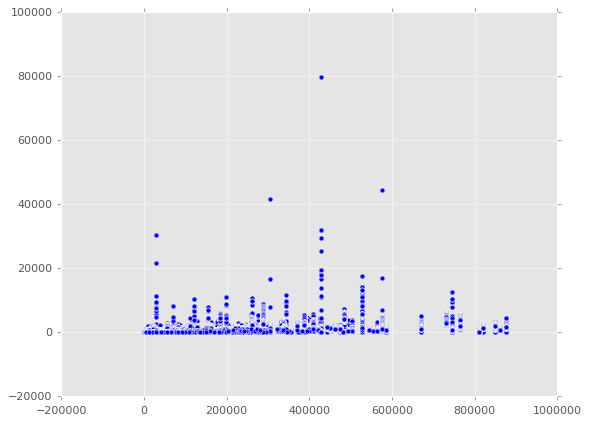

In [26]:
plt.scatter(df.loc[df['primary_use'] != 'Parking', 'square_feet'], df.loc[df['primary_use'] != 'Parking', 'meter_reading'])
plt.show()

- According to the above plot we looked at the building with highest consumption --> see below
 - Actions:
        * we need to scan all buildings, if the meter reading is extremely high (tbd) in compare to 
          previous and subsequent reading replace with the average of the two. -- 
          make sure that there is not a jump in the dates 
        * replace general meter reading outliers per site, month and primary usage 
        * also think how much it's reasonable for air temp to differ between hours

In [34]:
(df.loc[(df['building_id'] == '993') & (df['mon'] == 10) & (df['day'] == '17'), 
       ['timestamp', 'meter_reading', 'air_temperature']].head())

,timestamp,meter_reading,air_temperature
15959271,2016-10-17 00:00:00,0.0,30.0
15961428,2016-10-17 01:00:00,31921.0,28.3
15963761,2016-10-17 02:00:00,0.0,27.2
15966098,2016-10-17 03:00:00,0.0,27.2
15968436,2016-10-17 04:00:00,0.0,25.6


### Correlation plot

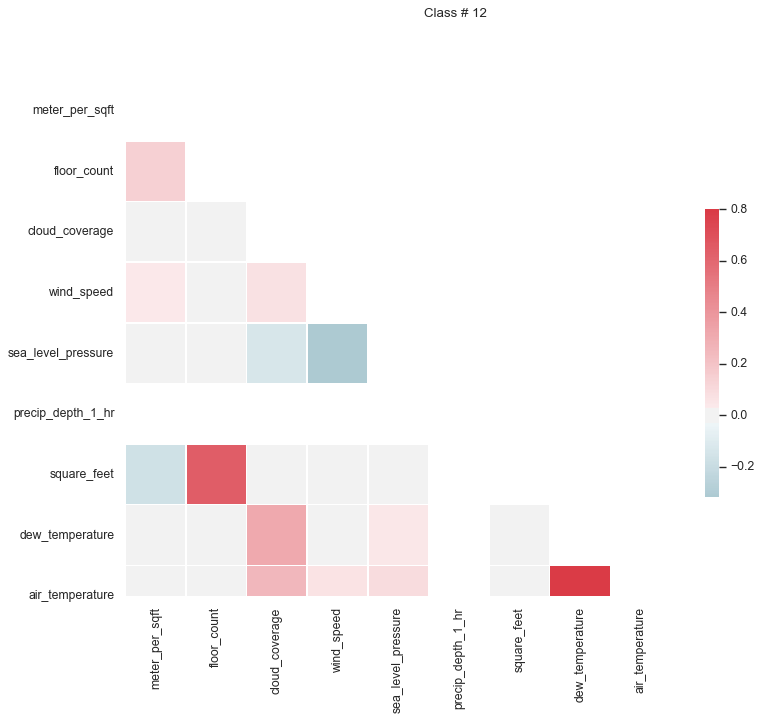

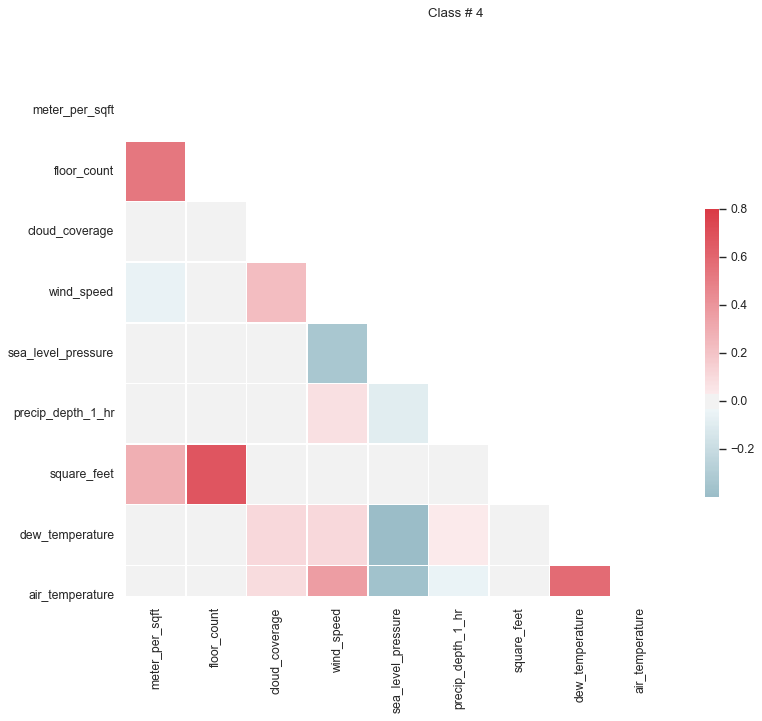

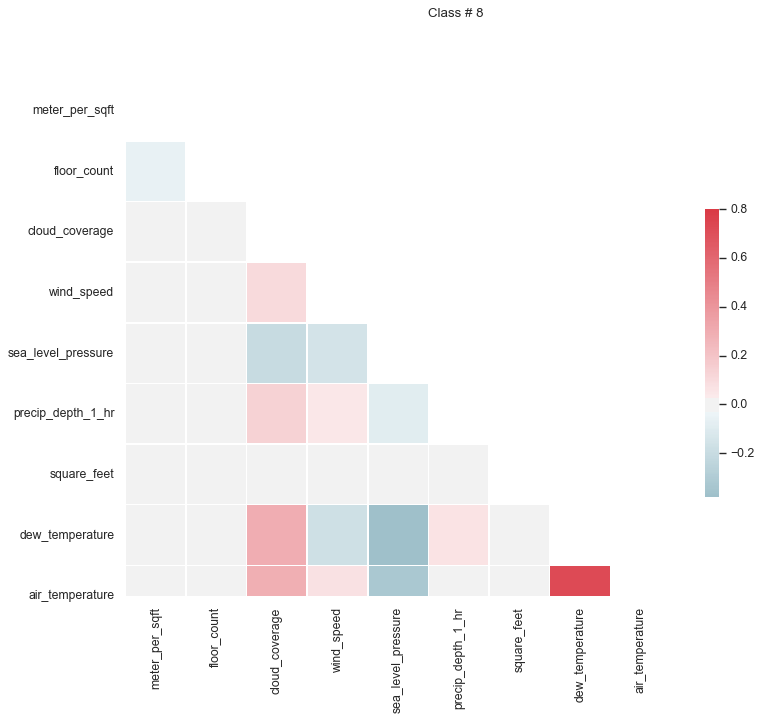

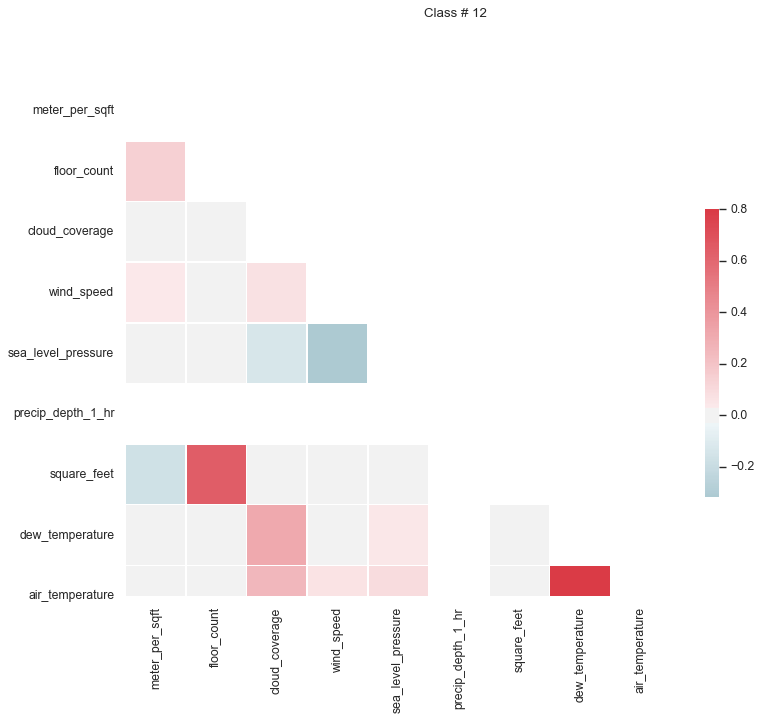

In [35]:
plo.sns_correlation_per_class(df, 'site_id', ['meter_per_sqft', 'floor_count','cloud_coverage', 'wind_speed', 'sea_level_pressure' ,'precip_depth_1_hr', 'square_feet', 'year_built', 'dew_temperature' ,'air_temperature'])

- Correlations are different per site. This is another support for per site random variables. 
It should be noted that correlation is a linear relationship, and thus even if it is low, 
there might be more intricate realtionships that we want to capture.

<h2 style="color: red";> What's happening at site #0 and #7 and #9? </h2> --- Still not ready section 

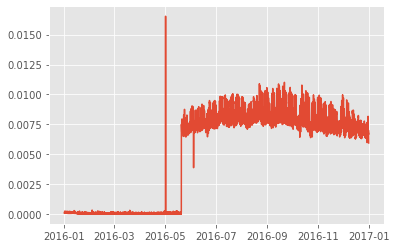

In [256]:
site_0 = df2[df2['site_id'] == 0]
plt.plot(site_0.timestamp, site_0.meter_per_sqft)

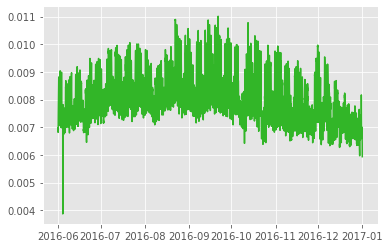

In [263]:
df_day = df.groupby(['day', 'site_id']).mean().reset_index()[['timestamp', 'site_id' ,'meter_per_sqft']]
site_o = df_day[df_day['site_id'] == 0]
plt.plot(site_o.loc[site_o['timestamp'] > '2016-06-01', 'timestamp'], site_o.loc[site_0['timestamp'] > '2016-06-01', 'meter_per_sqft'], c = np.random.rand(3,))
plt.show()

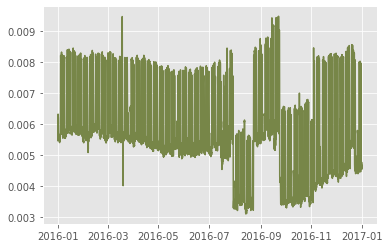

In [265]:
site_7 = df2[df2['site_id'] == 7]
plt.plot(site_7.timestamp, site_7.meter_per_sqft, c= np.random.rand(3,))

### Different sites same month (class)

class is:  5


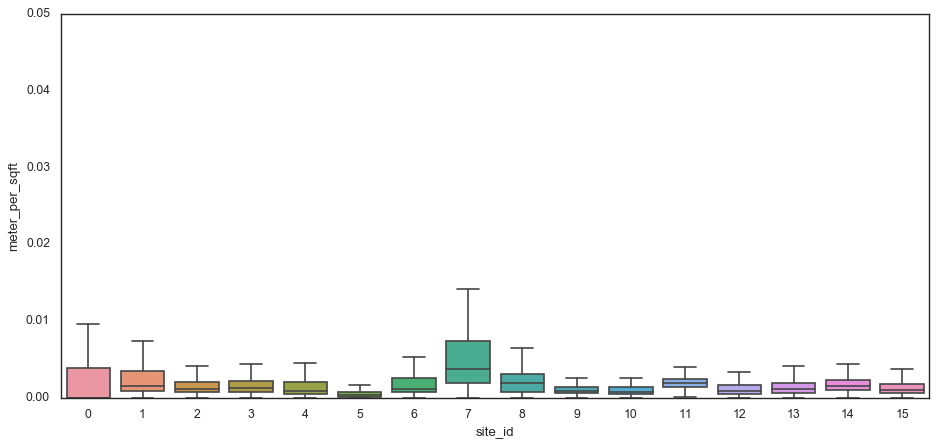

class is:  11


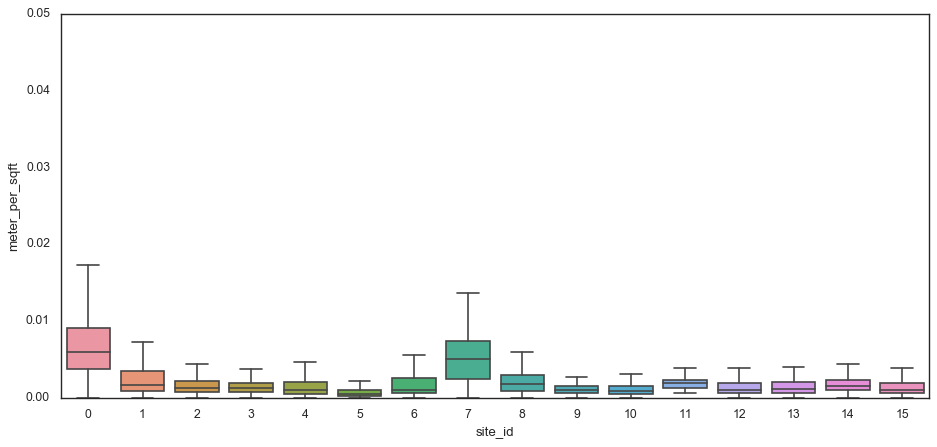

class is:  4


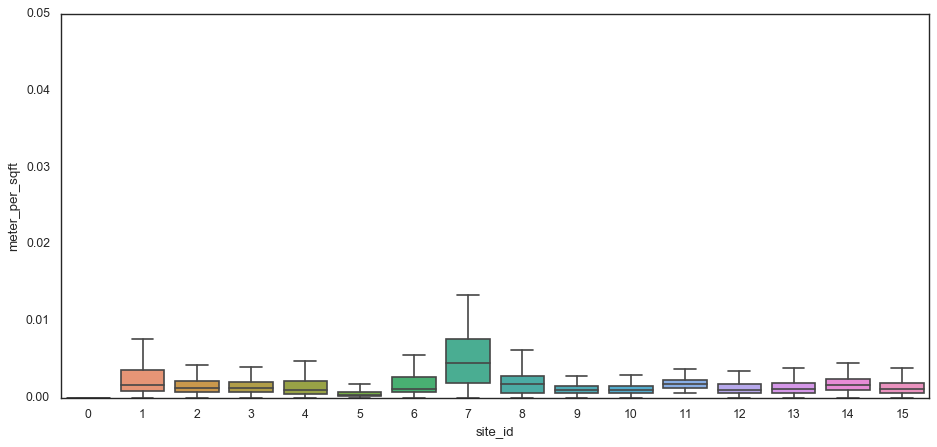

class is:  8


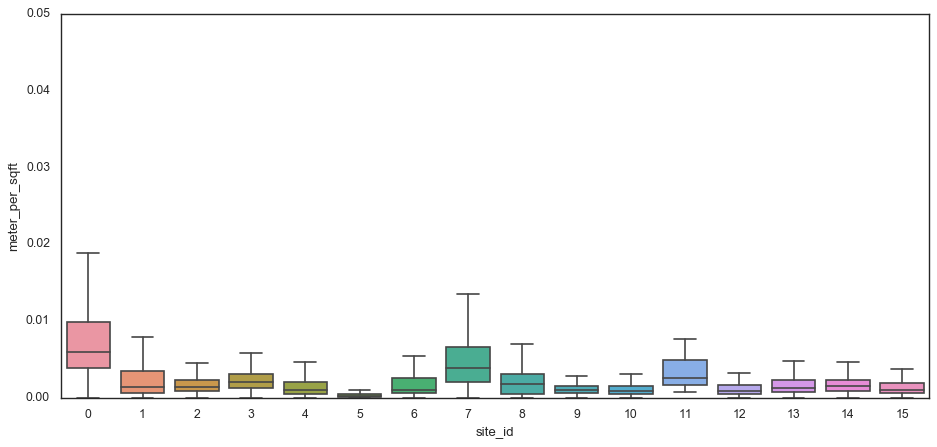

In [36]:
plo.plot_sns_usages_multi_boxplots_multi_class(df, x = 'site_id', y = 'meter_per_sqft', class_col='mon')

### Different buildings same site

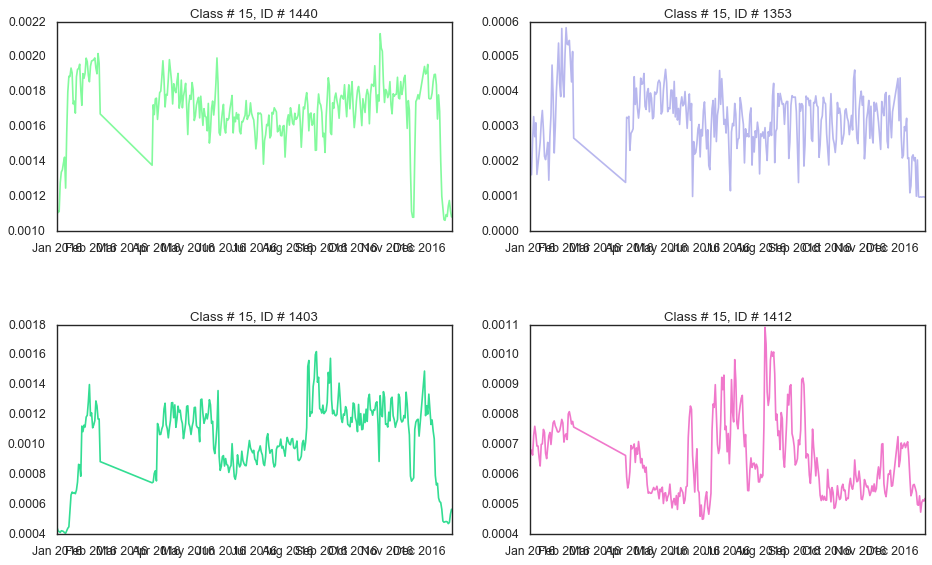

In [37]:
plo.check_different_ids_same_class(df, id_col = 'building_id', class_col='site_id', xaxis = 'date', yaxis = 'meter_per_sqft', group = 'date')

- Different buildings behave differently at the same site!
- i.e. we will need a model that has a building specific bias
Actions: 
    - Add building specific bias

### Different buildings, similar usage, same site

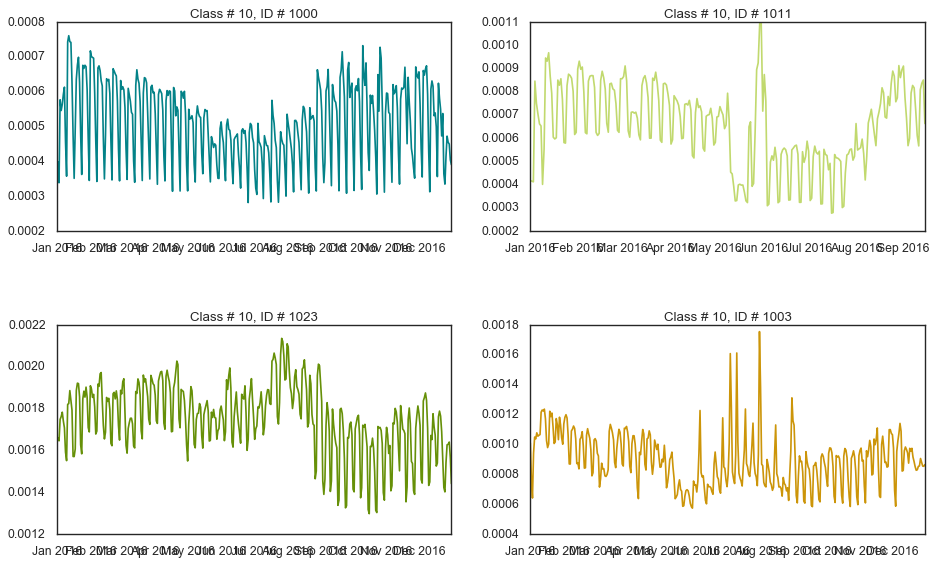

In [38]:
plo.check_different_ids_same_class(df[df['primary_use'] == 'Education'], 'building_id', 'site_id', 'date', 'meter_per_sqft', group = 'date')

### Exploration conclusions  

- All sites are in northern hemisphere 
- No dates for Site 15 from 2016-02-11 to 2016-03-29 incl. -- remove all zeros between these dates
- Site 0 doesn't have enetries up until 2016-06-01 -- remove all zeros prior to that date
- Our goal is to look at new buildings and new sites; i.e. we need a generative model (GP)
- Our test data seeks to generalize so we should include sites and times which aren't in the training 

## Addendum

#### Why CDD thresholding is problematic?  different appropriate thresholds for different sites

In [39]:
cdd_df = cdd.percentage_incharge_by_temp(df, 'site_id', 'meter_reading', 'air_temperature')

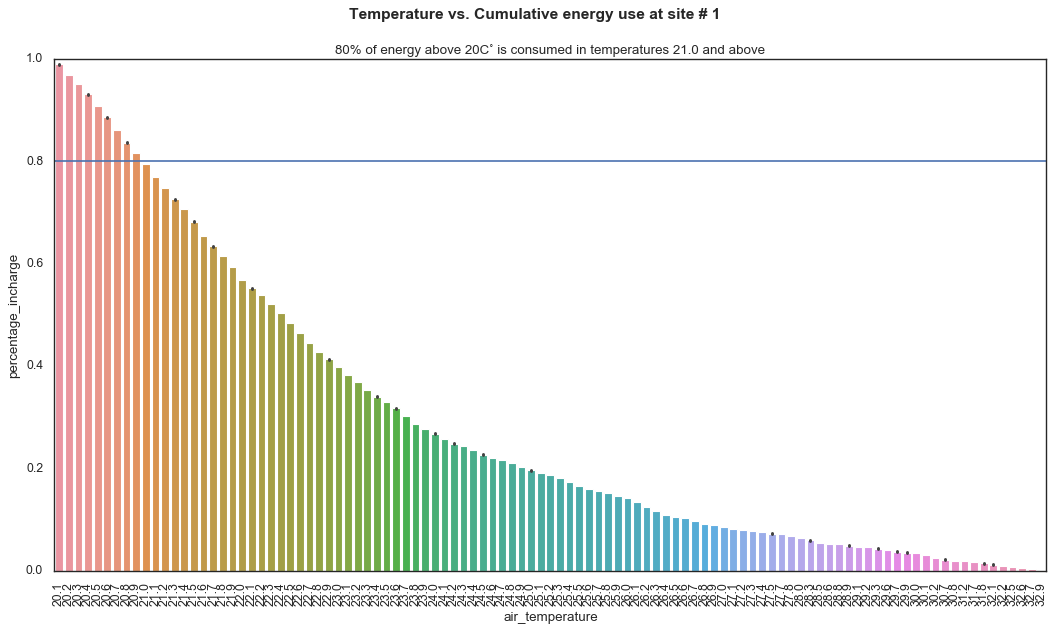

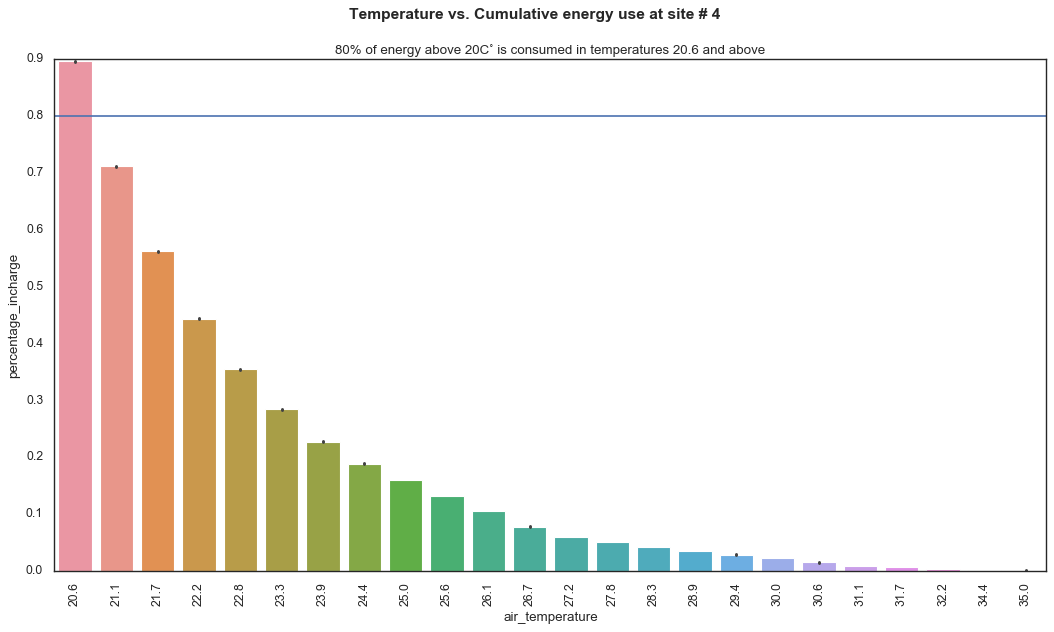

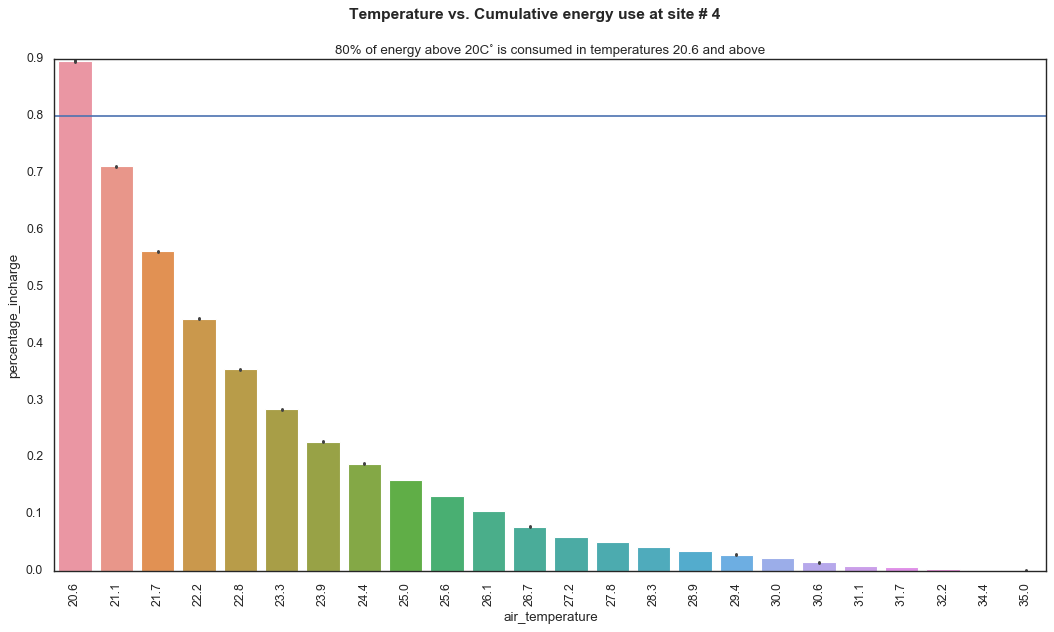

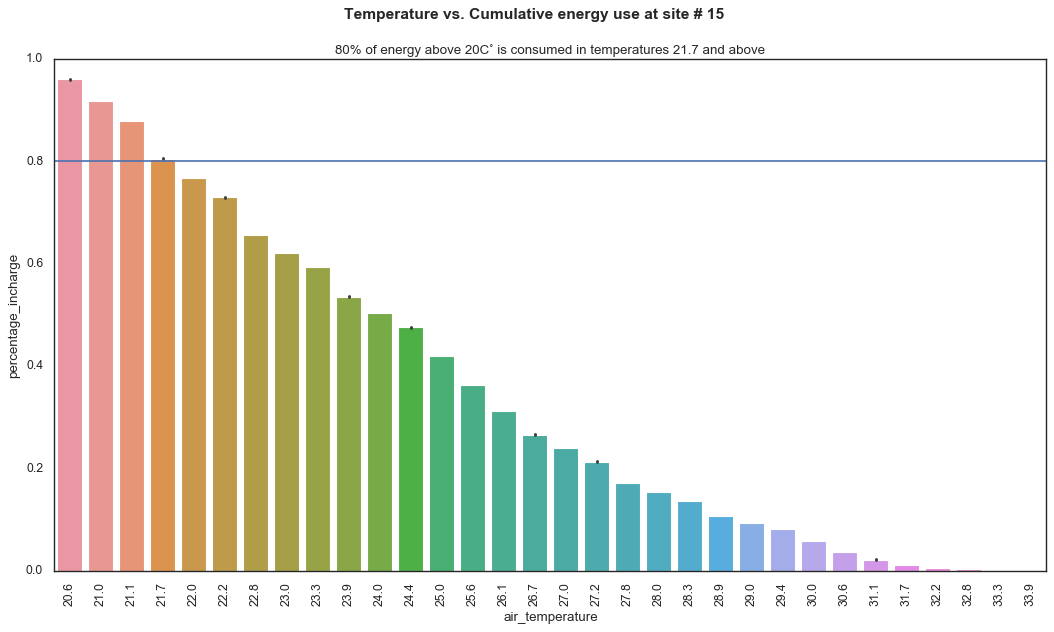

In [40]:
cdd.CDD_barplot(cdd_df, 'site_id')